## Import and Functions

In [2]:
import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
%matplotlib inline

2022-06-22 18:13:44.693511: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-22 18:13:44.730691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 18:13:44.730718: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Random Seeds and Data Import

In [4]:
# Set a seed value: 
keras.utils.set_random_seed(5)

In [5]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"]
    train_x_data     = var["train_x_data"][:]
    train_y_data     = var["train_y_data"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    test_y_sorted    = var["test_y_sorted"][:]
    freq             = var["freq"][:]

## Building Model

In [6]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 8)             32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 8)             200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 8)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 88)                0         
                                                                 
 dense (Dense)               (None, 8)                 7

2022-06-22 18:13:47.220696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 18:13:47.220712: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 18:13:47.220727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-22 18:13:47.221195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training algorithm

In [7]:
model.compile(loss = keras.losses.mean_absolute_percentage_error,#lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .0015), 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [8]:
step_num = 12800#int(len(train_y_data)//32)
history = model.fit(
    x=train_x_data[:], y=train_y_data[:], epochs=20, batch_size=32, steps_per_epoch=step_num,
    validation_split=.1, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

Epoch 1/20
12800/12800 - 12s - loss: 4.0589 - mean_absolute_percentage_error: 4.0589 - val_loss: 2.0593 - val_mean_absolute_percentage_error: 2.0593 - 12s/epoch - 975us/step
Epoch 2/20
12800/12800 - 13s - loss: 1.8596 - mean_absolute_percentage_error: 1.8596 - val_loss: 1.5762 - val_mean_absolute_percentage_error: 1.5762 - 13s/epoch - 1ms/step
Epoch 3/20
12800/12800 - 13s - loss: 1.4917 - mean_absolute_percentage_error: 1.4917 - val_loss: 1.3890 - val_mean_absolute_percentage_error: 1.3890 - 13s/epoch - 1ms/step
Epoch 4/20
12800/12800 - 13s - loss: 1.3057 - mean_absolute_percentage_error: 1.3057 - val_loss: 1.4021 - val_mean_absolute_percentage_error: 1.4021 - 13s/epoch - 996us/step
Epoch 5/20
12800/12800 - 14s - loss: 1.2209 - mean_absolute_percentage_error: 1.2209 - val_loss: 1.1972 - val_mean_absolute_percentage_error: 1.1972 - 14s/epoch - 1ms/step
Epoch 6/20
12800/12800 - 15s - loss: 1.1680 - mean_absolute_percentage_error: 1.1680 - val_loss: 1.1589 - val_mean_absolute_percentage_e

## Testing Model

In [9]:
perf = model.evaluate(test_x_sorted, test_y_sorted)

1581/1581 [==============================] - 1s 676us/step - loss: 0.9395 - mean_absolute_percentage_error: 0.9395


In [10]:
pred_y = model.predict(test_x_sorted)

1581/1581 [==============================] - 1s 563us/step


In [28]:
denorm_test = denorm(test_y_sorted, max_y)
denorm_pred = denorm(pred_y, max_y)[:,0]
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))
lst2 = list(map(lambda i: (denorm_pred[i]-denorm_test[i])**2,
               range(len(pred_y))))
error = np.sqrt(sum(lst2)/len(lst2))
print(f"Each predicted value has an error of ±{np.mean(lst)/np.sqrt(len(lst))}% or ±{error} kHz")
print(f"The average predicted value is {np.mean(denorm_pred)}")
print(f"Predicted first value: {denorm_pred[i]} ±{error} kHz")
pd.DataFrame(denorm_pred).describe()

Each predicted value has an error of ±4.177706325923662e-05% or ±0.4939827273532616 kHz
The average predicted value is 25.33702850341797
Predicted first value: 14.859745025634766 ±0.4939827273532616 kHz


,0
count,50573.000000
mean,25.337029
std,9.142189
min,12.270255
25%,18.499884
50%,21.328650
75%,31.741518
max,83.488045


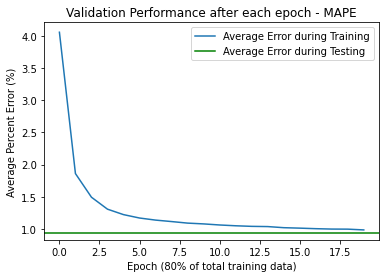

In [13]:
plt.figure(facecolor='w')
plt.title("Validation Performance after each epoch - MAPE")
plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
plt.axhline(perf[1], color='g', label="Average Error during Testing")
plt.xlabel("Epoch (80% of total training data)")
plt.ylabel("Average Percent Error (%)")
plt.legend()
plt.savefig("plots/validation_performance_over_time_mape.png", dpi=500)

1581/1581 [==============================] - 1s 617us/step


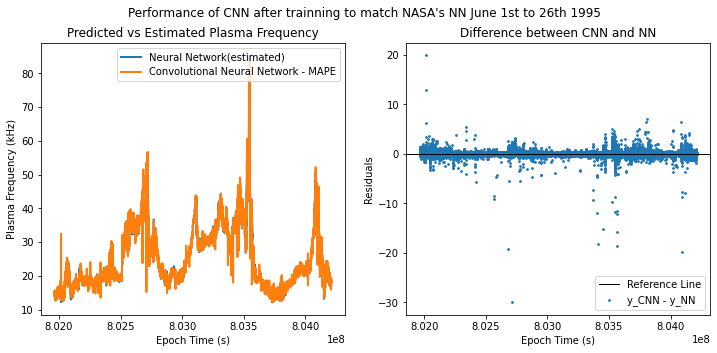

In [14]:
pred_y = model.predict(test_x_sorted)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
fig.suptitle("Performance of CNN after trainning to match NASA's NN June 1st to 26th 1995")

ax0.plot(test_time_sorted, denorm_test, label="Neural Network(estimated)",linewidth=2)
ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network - MAPE",linewidth=2)
ax0.set_title("Predicted vs Estimated Plasma Frequency")
ax0.set_xlabel("Epoch Time (s)")
ax0.set_ylabel("Plasma Frequency (kHz)")
ax0.legend()

res = np.subtract(denorm(pred_y, max_y)[:,0],denorm(test_y_sorted, max_y))
ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_NN")
denorm_test = denorm(test_y_sorted, max_y)
for i in range(len(res)):
    if denorm_test[i] < 10:
        ax1.scatter(test_time_sorted[i], res[i], s=3, color='r')

ax1.set_title("Difference between CNN and NN")
ax1.set_xlabel("Epoch Time (s)")
ax1.set_ylabel("Residuals")
ax1.legend(loc='lower right')

fig.savefig("plots/performance_on_test_dataset_mape.png", dpi=500)

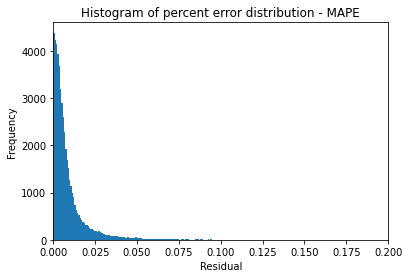

In [15]:
fig, ax = plt.subplots(facecolor='w')
ax.hist(lst, 2000, histtype='bar')
plt.xlim((0,.2))
ax.set_title("Histogram of percent error distribution - MAPE")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
#plt.show()
plt.savefig("plots/hist_mape.png", dpi=500)

In [16]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                           lst: 434.0 KiB
                          lst2: 434.0 KiB
                   denorm_test: 395.2 KiB
                           res: 395.2 KiB
                        pred_y: 197.7 KiB
                           _ii:  1.1 KiB
                          _i14:  1.1 KiB
                       Dropout:  1.0 KiB
                    Sequential:  904.0 B
                         Dense:  904.0 B


In [35]:
#with open("data/pickle/error_dist", 'wb') as file:
#    pickle.dump(data_dic, file=open("data/pickle/data", 'wb'))
help(filter)

Help on class filter in module builtins:

class filter(object)
 |  filter(function or None, iterable) --> filter object
 |  
 |  Return an iterator yielding those items of iterable for which function(item)
 |  is true. If function is None, return the items that are true.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [22]:
# Finding all outliers with a frequency error greater than 5
data_zip = list(filter(lambda x: abs(x[4])>5, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_outliers, test_x_sorted_outliers, test_y_sorted_outliers, pred_y_outliers, res_outliers = list(zip(*data_zip))

In [23]:
len(res_outliers)

31

IndexError: tuple index out of range

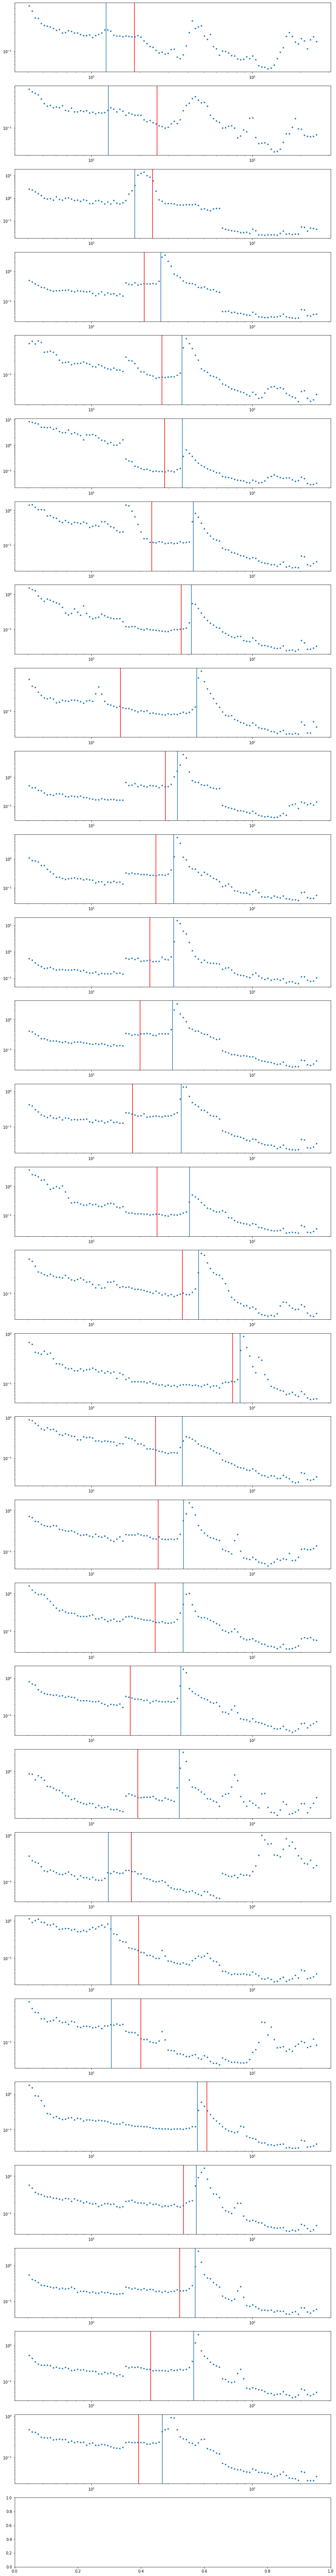

In [50]:
point = 100
n = len(res_outliers)
peakshift = (1 + 8*(1/7.3916)**2)
plt.figure(figsize=(15, 1+4*n))
for i in range(1, n+1):
    #plt.subplot(n,1, i)
    
    plt.plot(freq/1000, test_x_sorted_outliers[i], 'o', markersize=3, label='WIND data')
    f = freq[max(range(len(freq)), key=lambda x: test_x_sorted_outliers[i][x] if freq[x]/1000>10 else 0)]/1000

    plt.axvline(x=denorm(pred_y_outliers, max_y)[i], color='r')
    plt.axvline(x=denorm(test_y_sorted_outliers, max_y)[i])
    plt.xscale('log')
    plt.yscale('log')
#print(pred_y[point], test_y_sorted[point])
#print(pred_y[point]*max(y_data), test_y_sorted[point]*max(y_data))
#max(pred_y)
plt.show()

AttributeError: 'Figure' object has no attribute 'set_suptitle'

<Figure size 1080x8928 with 0 Axes>

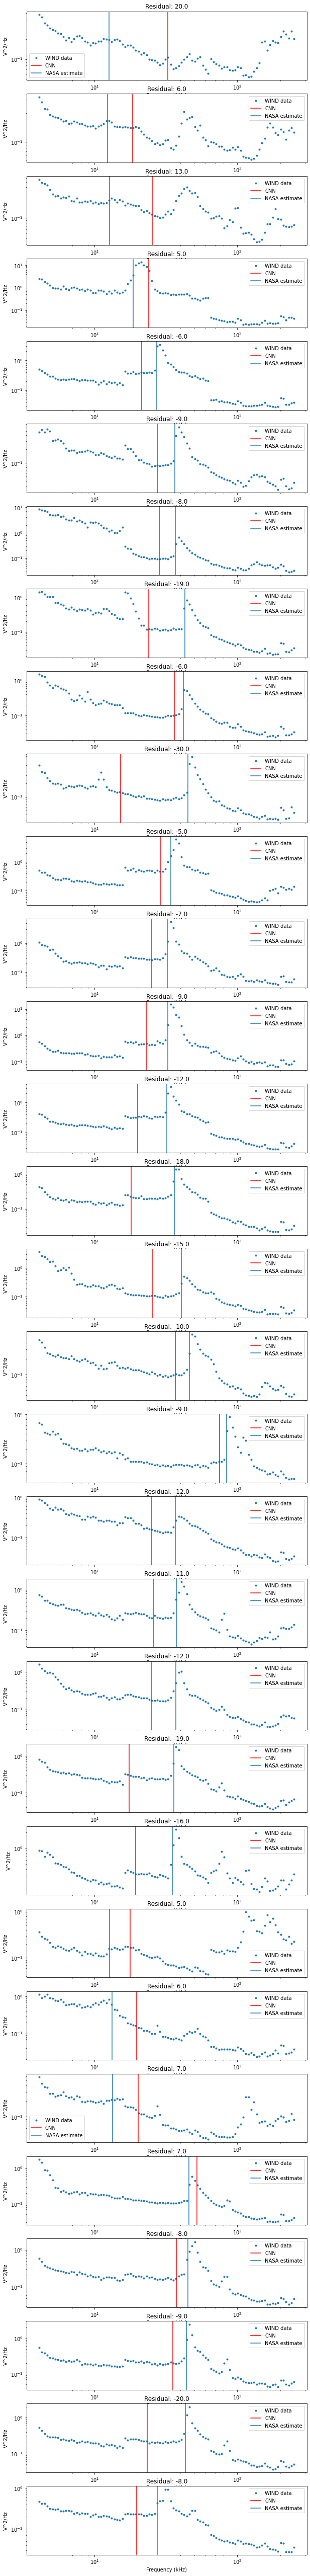

In [26]:
n = len(res_outliers)
plt.figure(figsize=(15, 4*n))
fig, ax = plt.subplots(nrows=n, ncols=1,figsize=(10, 3*n))

for i in range(0, n):
    ax[i].set_title(f"Residual: {np.round(res_outliers[i])}")
    ax[i].set_xlabel("Frequency (kHz)")
    ax[i].set_ylabel("V^2/Hz")
    ax[i].plot(freq/1000, test_x_sorted_outliers[i], 'o', markersize=3, label='WIND data')
    ax[i].axvline(x=denorm(pred_y_outliers, max_y)[i], color='r', label="CNN")
    ax[i].axvline(x=denorm(test_y_sorted_outliers, max_y)[i], label="NASA estimate")
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].legend()
    
fig.set_suptitle("The plot of the spectra with CNN and NASA estimate for plasma frequency")

plt.show()